In [1]:
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import numpy as np
import pandas as pd
#import xml.etree.ElementTree as ET
import xarray as xr
#import hvplot.xarray
#import rasterio as rio
import pickle
from matplotlib import cm
#from rasterio.plot import show
from datetime import datetime
# from scipy import interpolate
# from astropy.convolution import Gaussian2DKernel, convolve

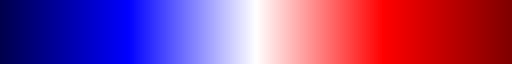

In [119]:
# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'
red3 = ['#fee0d2','#fc9272','#de2d26']
ored3 = ['#fff7bc','#fec44f','#d95f0e']
# oranges from ColorBrewer https://colorbrewer2.org/#type=sequential&scheme=PuBu&n=5
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
blue5=['#f1eef6','#bdc9e1','#bdc9e1','#2b8cbe','#045a8d']
green5=['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
purple5 = ['#f2f0f7','#cbc9e2','#9e9ac8','#756bb1','#54278f']

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

# This makes NaN gray
tcmap=cmap_ncb
tcmap.set_bad(color='darkgray')

# This is the difference color map
dcmap = cm.seismic.copy()
dcmap.set_bad(color='darkgray')

ygbmap = cm.YlGnBu_r.copy()
ygbmap.set_bad(color='darkgray')

prmap = cm.PuRd.copy()
prmap.set_bad(color='darkgray')

dcmap

In [25]:
fig_dir = '/vortexfs1/home/csherwood/proj/dorian/'

In [3]:
def running_mean(y, npts):
    '''
    Smooth a 1-d array with a moving average
    https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

    Input:
        y - 1-d array
        npts - number of points to average
    Returns:
        ys - smoothed arrays
    '''
    box = np.ones(npts)/npts
    ys = np.convolve(y, box, mode='same')
    return ys

In [4]:
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/dorian_032/dorian_his.ncml'

ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:                 (tracer: 2, NST: 1, s_rho: 5, s_w: 6,
                             eta_rho: 1017, xi_rho: 1317, eta_u: 1017,
                             xi_u: 1316, eta_v: 1016, xi_v: 1317,
                             eta_psi: 1016, xi_psi: 1316, ocean_time: 24,
                             NVEG: 3, Nbed: 1)
Coordinates:
  * s_rho                   (s_rho) float64 -0.9 -0.7 -0.5 -0.3 -0.1
  * s_w                     (s_w) float64 -1.0 -0.8 -0.6 -0.4 -0.2 0.0
    lon_rho                 (eta_rho, xi_rho) float64 ...
    lat_rho                 (eta_rho, xi_rho) float64 ...
    lon_u                   (eta_u, xi_u) float64 ...
    lat_u                   (eta_u, xi_u) float64 ...
    lon_v                   (eta_v, xi_v) float64 ...
    lat_v                   (eta_v, xi_v) float64 ...
    lon_psi                 (eta_psi, xi_psi) float64 ...
    lat_psi                 (eta_psi, xi_psi) float64 ...
  * ocean_time              (ocean_time) datetime64[ns] 2019-09-06T11:14:59.9...
Dimensions without coordinates: tracer, NST, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi, NVEG, Nbed
Data variables: (12/173)
    ntimes                  int32 ...
    ndtfast                 int32 ...
    dt                      float64 ...
    dtfast                  float64 ...
    dstart                  datetime64[ns] ...
    nHIS                    int32 ...
    ...                      ...
    Dwave                   (ocean_time, eta_rho, xi_rho) float32 ...
    Pwave_top               (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_fric             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_break            (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_wcap             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_roller           (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/33)
    file:                      ./Output/Dorian_NCB_his_00016.nc
    format:                    netCDF-3 64bit offset file
    Conventions:               CF-1.4, SGRID-0.3
    type:                      ROMS/TOMS history file
    title:                     Hurricane Dorian North Core Banks
    var_info:                  ./ROMS/External/varinfo.dat
    ...                        ...
    tiling:                    021x012
    history:                   ROMS/TOMS, Version 3.9, Monday - May 9, 2022 -...
    ana_file:                  ROMS/Functionals/ana_btflux.h, ROMS/Functional...
    CPP_options:               COREBANKS, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX,...
    EXTRA_DIMENSION.N:         5
    EXTRA_DIMENSION.boundary:  4

In [5]:
### load the grid files
url = '/vortexfs1/scratch/jwarner/dorian/NCoreBanks_sub9_chrisbathy.nc'
ds_grid = xr.open_dataset(url)
x = ds_grid.eta_rho
y = ds_grid.xi_rho

In [6]:
pm = ds_grid.pm # dx = 1/pm. pm has constant value of 0.667
pn = ds_grid.pn # dy = 1/pn. pn varies from 0.667 to 0.067
bathy32_0 = -ds_grid.h # initial model grid

### This is the URL for another run with much less erosion
url31='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/dorian_031/dorian_his.ncml'  
ds31 = xr.open_dataset(url31)  
ds31  

### pre/post bathy for

In [7]:
bathy32_4 = -ds.bath[4,:,:]
bathy32_23 = -ds.bath[23,:,:]
# bathy31_4 = -ds31.bath[4,:,:]
# bathy31_23 = -ds31.bath[23,:,:]

In [8]:
xs, xe = 650, 1050
ys, ye = 100, 500
subx = range(xs,xe+1)
suby = range(ys,ye+1)

prx = 858
pry = 205


t=ds.ocean_time  
tstring = np.datetime_as_string(t, unit='m')  
tstring.shape  
tstring  

In [86]:
t=ds.ocean_time.load()
tstring = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M')
tstring

Index(['2019-09-06 11:14', '2019-09-06 11:29', '2019-09-06 11:44',
       '2019-09-06 12:00', '2019-09-06 12:15', '2019-09-06 12:30',
       '2019-09-06 12:45', '2019-09-06 13:00', '2019-09-06 13:15',
       '2019-09-06 13:30', '2019-09-06 13:45', '2019-09-06 14:00',
       '2019-09-06 14:15', '2019-09-06 14:29', '2019-09-06 14:44',
       '2019-09-06 14:59', '2019-09-06 15:14', '2019-09-06 15:29',
       '2019-09-06 15:45', '2019-09-06 16:00', '2019-09-06 16:15',
       '2019-09-06 16:30', '2019-09-06 16:45', '2019-09-06 17:00'],
      dtype='object')

In [ ]:
ds.Hwave[4:23,suby,prx].plot()

In [ ]:
ds.zeta[4:23,suby,prx].plot()

In [99]:
# mask out water surface
# times to plot are 9, 14
itime = 9
wdm = ds.wetdry_mask_rho[itime,:,:]
zeta = ds.zeta[itime,:,:]
wdm_shape = wdm.shape
print(wdm_shape)
wdmr = np.ravel(wdm)
zetar = np.ravel(zeta)
zetar[np.where(wdmr==0.)]=np.nan
zeta = np.reshape(zetar, wdm_shape)
print(np.sum(np.isnan(zeta)))

(1017, 1317)
88427


In [100]:
hwave = ds.Hwave[itime,:,:]
hwaver = np.ravel(hwave)
hwaver[np.where(wdmr==0.)]=np.nan
hwave = np.reshape(hwaver, wdm_shape)

tauc = np.sqrt(ds.bustrc[itime,:,:]**2+ds.bvstrc[itime,:,:]**2)
taucr = np.ravel(tauc)
taucr[np.where(wdmr==0.)]=np.nan
tauc = np.reshape(taucr, wdm_shape)

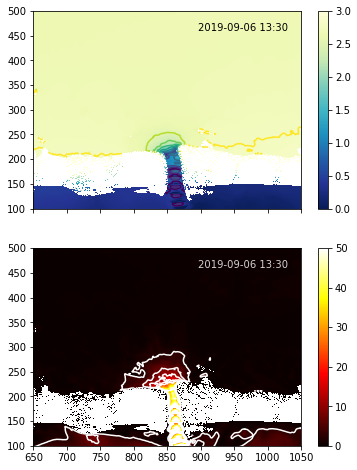

In [103]:
### plot of water surface
fig, (ax0, ax1 ) = plt.subplots(2,1,figsize=(6,8),sharex=True)
m0=ax0.pcolormesh(y,x,zeta,cmap='YlGnBu_r',vmin=0, vmax=3)
ax0.contour(y,x,zeta,np.arange(.5,3,.25))
plt.colorbar(m0, ax=ax0)
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.text(0.95, 0.9, '{}'.format(tstring[itime]), transform=ax0.transAxes, ha='right')


m1=ax1.pcolormesh(y,x,tauc,cmap='hot',vmin=0, vmax=50)
ax1.contour(y,x,tauc,np.arange(2,23,5),colors='white')
plt.colorbar(m1, ax=ax1)
ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.text(0.95, 0.9, '{}'.format(tstring[itime]), transform=ax1.transAxes, color='lightgray', ha='right')

plt.savefig(fig_dir+'zeta_tauc_zoom_9.png',dpi=200)

In [42]:
zetap = ds.zeta[:,:,prx-1:prx+2].load()
zetap = np.nanmean(zetap,2)

In [43]:
bp = ds.bath[:,:,prx-1:prx+2].load()
bp = np.nanmean(bp,2)

In [44]:
wm = ds.wetdry_mask_rho[:,:,prx-1:prx+2].load()
wm = np.nanmean(wm,2)

In [54]:
yp = ds_grid.eta_rho.load()
dy = np.diff(yp)
dy = np.append(dy,dy[-1])

In [50]:
# nan out zeta where wetdry_mask == 0
wm_shape = wm.shape
wmr = np.ravel(wm)
zr = np.ravel(zetap)
zr[np.where(wmr==0.)]=np.nan
zetap = np.reshape(zr, wm_shape)

In [51]:
# average three transects
zetap.shape

(24, 1017)

In [52]:
# smooth w/ running mean
zetaps = np.nan*np.ones_like(zetap)
for i in range(24):
    zetaps[i] = running_mean( zetap[i,:],21)

In [58]:
slope = np.nan*np.ones_like(zetap)
for i in range(24):
    dh = np.diff(zetaps[i,:])
    dh = np.append(dh, dh[-1])
    slope[i,:] = dh/dy

In [95]:
print(zetap.shape)
print(slope.shape)
mx_slope = np.nanmax(slope,1)
mx_slope
for i in range(14):
    print(tstring[i],np.nanmax(slope[i]))

(24, 1017)
(24, 1017)
2019-09-06 11:14 0.021823615
2019-09-06 11:29 0.021116346
2019-09-06 11:44 0.019830972
2019-09-06 12:00 0.04603088
2019-09-06 12:15 0.06299281
2019-09-06 12:30 0.06161928
2019-09-06 12:45 0.09452522
2019-09-06 13:00 0.06840205
2019-09-06 13:15 0.078997016
2019-09-06 13:30 0.06735003
2019-09-06 13:45 0.094999194
2019-09-06 14:00 0.049515963
2019-09-06 14:15 0.020421803
2019-09-06 14:29 0.015996456


In [ ]:
plt.plot(zetaps[4,suby])
plt.plot(zetaps[8,suby])
plt.plot(zetaps[12,suby])
plt.plot(zetaps[16,suby])
plt.plot(zetaps[23,suby])


In [ ]:

plt.plot(-bp[4,suby])
plt.plot(-bp[8,suby])
plt.plot(-bp[12,suby])
plt.plot(-bp[16,suby])
plt.plot(-bp[23,suby])

In [62]:
ycross = yp[suby]
floor = np.ones_like(bp[0,suby])*-2.8
# plt.fill_between(x,-bp[4,suby],floor,color=ored3[1])
# plt.plot(x,zetaps[4,suby])

In [64]:
ycross.shape

(401,)

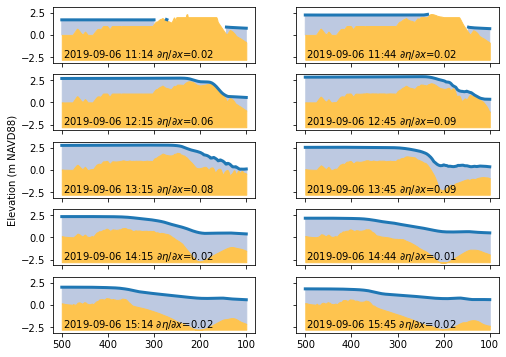

In [123]:
fig, axes = plt.subplots(5,2,figsize=(8,6),sharex=True,sharey=True)
i=0
for ax in (axes.flatten()):
    ax.fill_between(ycross,zetaps[i,suby],-bp[i,suby],color=blue5[1])
    ax.fill_between(ycross,-bp[i,suby],floor,color=ored3[1])
    ax.plot(ycross,zetaps[i,suby],linewidth=3)
    # ax.text((0.1, 0.1,r'\TeX\ is Number $\displaystyle\sum_{n=1}^\infty'
    #          r'\frac{-e^{i\pi}}{2^n}$!', fontsize=16, color='r'
    eqn = r" ${\partial \eta} / {\partial x}$="
    slp_mx = '{:.2f}'.format(np.nanmax(slope[i]))
    ax.text(0.05, 0.1, '{}'.format(tstring[i])+eqn+slp_mx, transform=ax.transAxes)
    i += 2
    
ax.invert_xaxis()
plt.subplots_adjust(hspace = 0.2)
axes[2,0].set_ylabel('Elevation (m NAVD88)')
plt.savefig(fig_dir+'zeta_profiles.png',dpi=200)

In [ ]:
ax.flatten()

In [ ]:



plt.pcolormesh((zeta)[100:400,700:1000],cmap=ygbmap,vmin=0,vmax=3.)
plt.colorbar()
plt.title('Water Surface Elevation (m)')

In [ ]:
ds.zeta.isel(ocean_time=0).plot(x="lon_rho", y="lat_rho")

In [ ]:
ds.bed_thickness.isel(ocean_time=14).plot()

In [ ]:
dmap = ds.bath[-1,0:400,:].plot()


In [ ]:
ds.zeta.isel(ocean_time=0).plot()
plt.plot(600,100,'or')

In [ ]:
ds.zeta.isel(xi_rho=850,eta_rho=100,ocean_time=range(0,15)).plot()
ds.zeta.isel(xi_rho=850,eta_rho=400,ocean_time=range(0,15)).plot()

In [ ]:
ds.zeta[0,200:600,600].plot()
ds.zeta[7,200:600,600].plot()
